# Biodiversity Intactness Index change in Phoenix, AZ

**[Repository](https://github.com/richardmonteslemus/maricopa_bii)**

**Author: [Richard Montes Lemus](https://richardmonteslemus.github.io/)**

# About

## Purpose

Maricopa County contains the Phoenix metropolitan area and is the U.S. county with the most significant increase in developed land since 2001 (Levitt & Eng, 2021). This rapid urban sprawl has profound implications for biodiversity and the health of surrounding natural ecosystems.

This analysis will use Biodiversity Intactness Index (BII) to measure and visualize the impact of this urban expansion on ecosytems(Gassert et al., 2022). It will examine changes in BII in the Phoenix county subdivision area between 2017 and 2020, shedding light on how urban growth affects biodiversity over time.

### Highlights
* Load in Phoenix sub-divison data and explore 
* Access BII data and explore 
* Calculate difference in BII >= 0.75 between 2017 and 2020
* Create map representing areas with high biodiversity lost between 2017 and 2020 

### Data: 
**Biodiversity Intactness Index (BII) Time Series:** This BII time series can be obtained through the [Microsoft Planetary Computer STAC Catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). It contains a 2017 and 2020 raster covering the Phoenix subdivision. It is read in as `phx_bii`. 

**Phoenix Subdivision Shapefile:** This shapefile polygon can be obtained through [TIGER Shapefiles](https://www.census.gov/cgi-bin/geo/shapefiles/index.php). It contains Census County Subdivisions for Arizona. It is read in as `az_county`.

| References |
|---------------------|
| Gassert, F., Mazzarello, J., & Hyde, S. (2022, August). Global 100m projections of biodiversity intactness for the years 2017-2020 [Technical whitepaper]. https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf |
 Impact Observatory. (2022). 10m annual land use land cover (9-class) [Data set]. Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/dataset/io-lulc-annual-v02 |
| Levitt, Z., & Eng, J. (2021, August). Where America's developed areas are growing: 'Way off into the horizon'. The Washington Post. https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/ |
U.S. Census Bureau. (2023). TIGER/Line shapefiles: Arizona county subdivisions [Data set]. https://www2.census.gov/geo/tiger/TIGER2023/COUSUB/tl_2023_04_cousub.zip|



In [87]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
from shapely import box
from shapely.geometry import Polygon
import planetary_computer
from pystac_client import Client
from IPython.display import Image 
import contextily as ctx

### Load in Arizona County Shapefile Polygons 

In [88]:
# Load in arizona county polygons
fp = os.path.join("data", "tl_2024_04_cousub", "tl_2024_04_cousub.shp")
az_county = gpd.read_file(fp)

# Clean columns
az_county.columns = az_county.columns.str.lower()

### Explore Arizona County Shapefile

In [89]:
# Print first few rows of dataframe 
az_county.head()

,statefp,countyfp,cousubfp,cousubns,geoid,geoidfq,name,namelsad,lsad,classfp,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231962349,44576380,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864156,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,0600000US0402392295,Nogales,Nogales CCD,22,Z5,G4040,S,1762339489,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,0600000US0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,S,1439560139,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


In [90]:
# Check `az_county` crs
print(az_county.crs)

EPSG:4269


**Exploration Summary**
The arizona county shapfile data contains sub-county division per row along with its geometry. We obtained this information form using the head() function to print the first few rows of our dataset. We also used the `.crs` attribute to discover its crs is EPSG: 4269 a datum for North America. 

### Extract Phoenix sub-county division from `az_county`

In [91]:
# Return Phoenix polygon
phx = az_county[az_county.name == "Phoenix"]

# Check if Phoenix was successfully extracted
print(phx.name)

10    Phoenix
Name: name, dtype: object


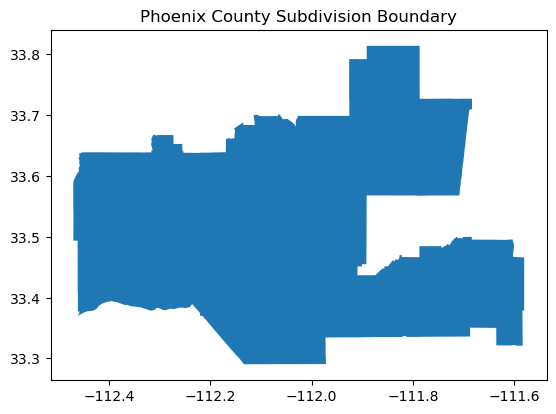

In [92]:
# Plot Phoenix Area
phx.plot()
plt.title("Phoenix County Subdivision Boundary")
plt.show()

### Access Biodiversity Intactness Impact Data

In [93]:
# Access catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Bound data to phoenix area
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Set date range 
dates = "2017-01-01/2021-01-01"

# Obtain BII data collection
search = catalog.search(collections=["io-biodiversity"],
                        bbox=bbox,
                        datetime=dates)
items = search.item_collection()

### Explore Biodiversity Intactness Impact Data and create 2017 and 2020 DataArray

In [94]:
# Ensure items has expected length of 4 objects corresponding to dates
print(len(items))

4


In [95]:
# Further explore collection information
items

In [96]:
# Read in BII data as DataArrays for 2017 and 2020
bii_2017 = rioxr.open_rasterio(items[3].assets["data"].href)
bii_2020 = rioxr.open_rasterio(items[0].assets["data"].href)

In [97]:
# Explore CRS of DataArrays
print(bii_2017.rio.crs)
print(bii_2020.rio.crs)

EPSG:4326
EPSG:4326


**Exploration Summary:** The collection contains raster files for the defined bounding box corresponding to the Phoenix area. Item 0 contains data for 2020 and item 3 contains data for 2017. The BII DataArray for 2017 and 2020 was found to have a crs of EPSG:4326.


### Transform CRS to match and Clip BII to Phoenix

In [98]:
# Transform phx polygon crs to match
phx = phx.to_crs("EPSG:4326")

# Return error if crs doesnt match
assert bii_2017.rio.crs == phx.crs
assert bii_2020.rio.crs == phx.crs


In [99]:
# Clip BII data to phoenix sub-division geometry and bounds
bii_2017_clipped = bii_2017.rio.clip_box(*phx.total_bounds).rio.clip(phx.geometry)
bii_2020_clipped = bii_2020.rio.clip_box(*phx.total_bounds).rio.clip(phx.geometry)

### Compare BII Change between 2020 and 2017

In [100]:
# Obtain BII greater than 0.75 for 2017 
high_bii_2017 = bii_2017_clipped >= 0.75
high_bii_2017_percent = (high_bii_2017.sum() / bii_2017_clipped.size) * 100

# Obtain BII greater than 0.75 for 2020
high_bii_2020 = bii_2020_clipped >= 0.75
high_bii_2020_percent = (high_bii_2020.sum() / bii_2020_clipped.size) * 100

print(f"BII Percentage greater than 0.75 in 2017: {high_bii_2017_percent.values:.2f}%")
print(f"BII Percentage greater than 0.75 in 2020: {high_bii_2020_percent.values:.2f}%")

BII Percentage greater than 0.75 in 2017: 4.18%
BII Percentage greater than 0.75 in 2020: 3.81%


**From 2017 to 2020 the BII In the Phoenix Sub Division Decreased from 4.18% to 3.81%**

### Create BII Raster Above 0.75 Lost Between 2017 and 2020

In [101]:
# Convert BII above 0.75 into Integer Booleans 
high_bii_2017 = high_bii_2017.astype(int)
high_bii_2020 = high_bii_2020.astype(int)

In [102]:
# Find difference in BII >= 0.75 between 2020 and 2017
high_bii_difference = high_bii_2017 - high_bii_2020

# Return raster containing 1, corresponding to BII >= 0.75 between 2020 and 2017
high_bii_lost = high_bii_difference.where(high_bii_difference != 0)

### Plot BII Raster Above 0.75 Lost Between 2017 and 2020

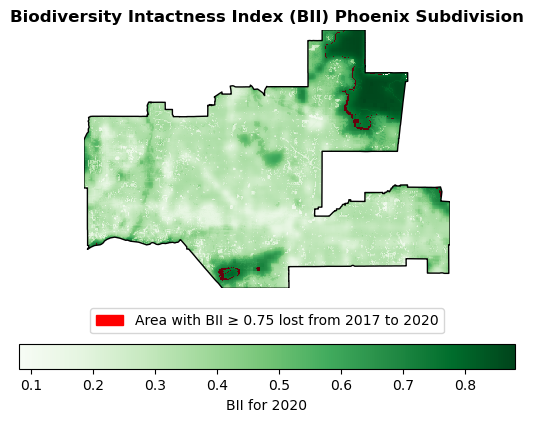

In [103]:
# Create figure
fig, ax = plt.subplots(1, 1)

# Remove axis for a clean plot
ax.axis('off')

# Plot 2020 BII with color bar
bii_2020_clipped.plot(ax = ax, 
                     cbar_kwargs = {'location': 'bottom', 'label':'BII for 2020'}, 
                     cmap = "Greens")

# Plot high BII lost in Red
high_bii_lost.plot(ax = ax, 
                   cmap = 'Reds', 
                   add_colorbar = False
                  )
# Plot Phoenix boundary
phx.plot(ax = ax,   
         edgecolor = 'black', 
         facecolor='none', 
         linewidth= 1)

# Customize legend
legend_elements = [patch.Patch(facecolor='red', edgecolor='r',
                         label='Area with BII ≥ 0.75 lost from 2017 to 2020')]
# Add legend 
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)

ax.set_title("Biodiversity Intactness Index (BII) Phoenix Subdivision", fontweight = 'bold')

plt.show()

**Map Takeaway:**The final plot visualizes the Biodiversity Intactness Index (BII) for the Phoenix sub-division of Arizona. Darker areas represent parts with higher Biodiversity in 2020. The red portion of this map represents areas that had a BII higher than 0.75 in 2017 but no longer do in 2020. This visualizes rapid biodiversity loss due to urban expansion. 